#### **Objective**

The goal is to benchmark different portfolio selection strategies. The idea is to simulate investing 10,000 USD at the beginning of each month using different portfolio allocation models, and then compare which strategy delivers the best performance over time.

The comparison will be based on:

- The evolution of the portfolio's total value over time.
- The allocation method used each month (e.g., Markowitz, equal-weight, etc.).
- Key metrics such as total return, volatility, and Sharpe ratio.


#### **1. Imports**

In [1]:
# %pip install selenium pandas

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
from datetime import datetime

#### **2. Variables**

In [ ]:
adjusted_close_prices_parquet = 'data/adjusted_close_prices.parquet'
market_cap_parquet = 'data/daily_market_cap.parquet'

end_date = datetime.today()
start_date = datetime(2004, 10, 31)
# start_date = datetime(end_date.year - 12, 10, 31)


search_all_tickers_flag = False
adjusted_closes_flag = False
market_cap_flag = False
execute_equal_weight_flag = False

#####################################

# adjusted_closes_flag = True
# market_cap_flag = True
# execute_equal_weight_flag = True

##### **2. Download - Asset Dataset**

In [4]:
MAX_ATTEMPTS = 10
BASE_URL = "https://finviz.com/screener.ashx"

USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)",
    "Mozilla/5.0 (X11; Linux x86_64)",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64)",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 12_4)"
]

def scrape_finviz_by_exchange_requests(exchange: str):
    exchange_map = {
        "nasdaq": "exch_nasd",
        "nyse": "exch_nyse"
    }

    if exchange.lower() not in exchange_map:
        raise ValueError("Invalid exchange. Use 'nasdaq' or 'nyse'.")

    exchange_code = exchange_map[exchange.lower()]
    all_data = []
    r = 1  # page offset

    while True:
        success = False
        attempts = 0

        while not success and attempts < MAX_ATTEMPTS:
            try:
                headers = {
                    "User-Agent": random.choice(USER_AGENTS)
                }
                params = {
                    "v": "111",
                    "f": exchange_code,
                    "r": r
                }
                response = requests.get(BASE_URL, headers=headers, params=params, timeout=10)
                if response.status_code == 429:
                    raise Exception("HTTP 429 Too Many Requests")
                response.raise_for_status()

                soup = BeautifulSoup(response.text, "html.parser")
                tables = soup.find_all("table")

                target_table = None
                for table in tables:
                    rows = table.find_all("tr")
                    if len(rows) < 2:
                        continue
                    cols = rows[1].find_all("td")
                    if len(cols) >= 11 and cols[0].text.strip().isdigit():
                        target_table = table
                        break

                if not target_table:
                    raise ValueError("No valid table found.")

                rows = target_table.find_all("tr")[1:]
                if not rows:
                    print(f"No more data on page starting at {r}. Stopping.")
                    return finalize(all_data, exchange)

                for row in rows:
                    cols = row.find_all("td")
                    if len(cols) >= 11:
                        ticker = cols[1].text.strip()
                        company = cols[2].text.strip()
                        sector = cols[3].text.strip()
                        industry = cols[4].text.strip()
                        country = cols[5].text.strip()
                        market_cap = cols[6].text.strip()
                        volume = cols[10].text.strip()
                        all_data.append([ticker, company, sector, industry, country, market_cap, volume])

                print(f"Page {r} OK")
                success = True
                r += 20

                # Simula navegação humana
                time.sleep(random.uniform(3, 6))

            except Exception as e:
                attempts += 1
                print(f"Error on page {r}, attempt {attempts}: {e}")
                time.sleep(5 * attempts + random.uniform(1, 3))  # backoff crescente

        if not success:
            print(f"\n⚠️  Page {r} failed {MAX_ATTEMPTS} times. Finalizing with partial data.")
            return finalize(all_data, exchange)

def finalize(all_data, exchange):
    df = pd.DataFrame(all_data, columns=[
        "Ticker", "Company", "Sector", "Industry", "Country", "Market Cap", "Volume"
    ])
    df = df[df["Volume"] != "0"].reset_index(drop=True)
    filename = f"data/tickers_{exchange.lower()}.csv"
    df.to_csv(filename, index=False)
    print(f"\n✅ Scraping finished. Saved {len(df)} tickers to '{filename}'")
    return df


##### **2.1 Nasdaq Tickers**

In [5]:
if search_all_tickers_flag:
    nasdaq = scrape_finviz_by_exchange_requests("nasdaq")
    nasdaq

nasdaq = pd.read_csv("data/tickers_nasdaq.csv")
nasdaq

Ticker                                            Company  \
0      AACB                          Artius II Acquisition Inc   
1      AACG                          ATA Creativity Global ADR   
2      AACI                        Armada Acquisition Corp. II   
3      AADR                AdvisorShares Dorsey Wright ADR ETF   
4       AAL                        American Airlines Group Inc   
...     ...                                                ...   
4231   ZVSA                           ZyVersa Therapeutics Inc   
4232   ZYBT                  Zhengye Biotechnology Holding Ltd   
4233   ZYME                                   Zymeworks BC Inc   
4234   ZYXI                                          Zynex Inc   
4235    ZZZ  Cyber Hornet S&P 500 and Bitcoin 75 /25 Strate...   

                  Sector                                  Industry Country  \
0              Financial                           Shell Companies     USA   
1     Consumer Defensive             Education & Training Services   China   
2              Financial                           Shell Companies     USA   
3              Financial                      Exchange Traded Fund     USA   
4            Industrials                                  Airlines     USA   
...                  ...                                       ...     ...   
4231          Healthcare                             Biotechnology     USA   
4232          Healthcare  Drug Manufacturers - Specialty & Generic   China   
4233          Healthcare                             Biotechnology     USA   
4234          Healthcare                      Medical Distribution     USA   
4235           Financial                      Exchange Traded Fund     USA   

     Market Cap      Volume  
0       298.12M           1  
1        67.45M     254,981  
2       321.12M           3  
3             -          20  
4         7.28B  24,043,012  
...         ...         ...  
4231      0.93M      18,248  
4232    256.85M       6,705  
4233    879.92M     402,780  
4234     42.03M     840,704  
4235          -         809  

[4236 rows x 7 columns]

##### **2.2 Nyse Tickers**


In [6]:
if search_all_tickers_flag:
    nyse = scrape_finviz_by_exchange_requests("nyse")
    nyse

nyse = pd.read_csv("data/tickers_nyse.csv")
nyse

Ticker                                         Company  \
0         A                        Agilent Technologies Inc   
1        AA                                      Alcoa Corp   
2       AAA  Alternative Access First Priority CLO Bond ETF   
3      AACT                 Ares Acquisition Corporation II   
4       AAM                     AA Mission Acquisition Corp   
...     ...                                             ...   
4669    ZTO                    ZTO Express (Cayman) Inc ADR   
4670    ZTR                    Virtus Total Return Fund Inc   
4671    ZTS                                      Zoetis Inc   
4672   ZVIA                                       Zevia PBC   
4673    ZWS                 Zurn Elkay Water Solutions Corp   

                  Sector                                  Industry Country  \
0             Healthcare                    Diagnostics & Research     USA   
1        Basic Materials                                  Aluminum     USA   
2              Financial                      Exchange Traded Fund     USA   
3              Financial                           Shell Companies     USA   
4              Financial                           Shell Companies     USA   
...                  ...                                       ...     ...   
4669         Industrials            Integrated Freight & Logistics   China   
4670           Financial                  Closed-End Fund - Equity     USA   
4671          Healthcare  Drug Manufacturers - Specialty & Generic     USA   
4672  Consumer Defensive                 Beverages - Non-Alcoholic     USA   
4673         Industrials            Pollution & Treatment Controls     USA   

     Market Cap     Volume  
0        32.14B    682,198  
1         7.44B  3,594,093  
2             -      6,048  
3       705.51M    209,977  
4       459.97M      2,413  
...         ...        ...  
4669     12.03B  2,439,145  
4670    342.65M    128,272  
4671     65.41B  1,582,264  
4672    219.33M    239,408  
4673      7.41B  1,115,303  

[4674 rows x 7 columns]

In [7]:
tickers = pd.concat([nasdaq, nyse], ignore_index=True)
tickers

Ticker                              Company              Sector  \
0      AACB            Artius II Acquisition Inc           Financial   
1      AACG            ATA Creativity Global ADR  Consumer Defensive   
2      AACI          Armada Acquisition Corp. II           Financial   
3      AADR  AdvisorShares Dorsey Wright ADR ETF           Financial   
4       AAL          American Airlines Group Inc         Industrials   
...     ...                                  ...                 ...   
8905    ZTO         ZTO Express (Cayman) Inc ADR         Industrials   
8906    ZTR         Virtus Total Return Fund Inc           Financial   
8907    ZTS                           Zoetis Inc          Healthcare   
8908   ZVIA                            Zevia PBC  Consumer Defensive   
8909    ZWS      Zurn Elkay Water Solutions Corp         Industrials   

                                      Industry Country Market Cap      Volume  
0                              Shell Companies     USA    298.12M           1  
1                Education & Training Services   China     67.45M     254,981  
2                              Shell Companies     USA    321.12M           3  
3                         Exchange Traded Fund     USA          -          20  
4                                     Airlines     USA      7.28B  24,043,012  
...                                        ...     ...        ...         ...  
8905            Integrated Freight & Logistics   China     12.03B   2,439,145  
8906                  Closed-End Fund - Equity     USA    342.65M     128,272  
8907  Drug Manufacturers - Specialty & Generic     USA     65.41B   1,582,264  
8908                 Beverages - Non-Alcoholic     USA    219.33M     239,408  
8909            Pollution & Treatment Controls     USA      7.41B   1,115,303  

[8910 rows x 7 columns]

#### **3. Process data**


In [8]:
tickers['Volume'] = tickers['Volume'].str.replace(',', '').astype(float)
tickers.sort_values(by="Volume", inplace=True, ascending=False)
tickers

Ticker                                            Company  \
2236   LOBO                           Lobo Ev Technologies Ltd   
3138   RAYA                    Erayak Power Solution Group Inc   
3724   TNON                                  Tenon Medical Inc   
8060   SOXS        Direxion Daily Semiconductor Bear 3X Shares   
2010   IXHL                            Incannex Healthcare Inc   
...     ...                                                ...   
6555   JDVI  John Hancock Disciplined Value International S...   
6656   KBUF  KraneShares 90% KWEB Defined Outcome January 2...   
4490   AUSM                Allspring Ultra Short Municipal ETF   
7753   ROPE                            Coastal Compass 100 ETF   
0      AACB                          Artius II Acquisition Inc   

                 Sector                                  Industry    Country  \
2236  Consumer Cyclical                        Auto Manufacturers      China   
3138        Industrials              Electrical Equipment & Parts      China   
3724         Healthcare                           Medical Devices        USA   
8060          Financial                      Exchange Traded Fund        USA   
2010         Healthcare  Drug Manufacturers - Specialty & Generic  Australia   
...                 ...                                       ...        ...   
6555          Financial                      Exchange Traded Fund        USA   
6656          Financial                      Exchange Traded Fund        USA   
4490          Financial                      Exchange Traded Fund        USA   
7753          Financial                      Exchange Traded Fund        USA   
0             Financial                           Shell Companies        USA   

     Market Cap       Volume  
2236     13.39M  277221913.0  
3138      4.35M  229545591.0  
3724     12.22M  211413022.0  
8060          -  200627421.0  
2010     38.40M  137451462.0  
...         ...          ...  
6555          -          1.0  
6656          -          1.0  
4490          -          1.0  
7753          -          1.0  
0       298.12M          1.0  

[8910 rows x 7 columns]

#### **4. Filter assets**

##### **4.1 Liquidity: Remove low liquidity**
- Filters out assets with insufficient daily trading volume.

In [9]:
tickers = tickers[tickers['Volume'] > 500_000]
tickers

Ticker                                      Company              Sector  \
2236   LOBO                     Lobo Ev Technologies Ltd   Consumer Cyclical   
3138   RAYA              Erayak Power Solution Group Inc         Industrials   
3724   TNON                            Tenon Medical Inc          Healthcare   
8060   SOXS  Direxion Daily Semiconductor Bear 3X Shares           Financial   
2010   IXHL                      Incannex Healthcare Inc          Healthcare   
...     ...                                          ...                 ...   
3060   QDEL                      QuidelOrtho Corporation          Healthcare   
7009    MPC                      Marathon Petroleum Corp              Energy   
8065   SPBO            SPDR Portfolio Corporate Bond ETF           Financial   
4586     BC                               Brunswick Corp   Consumer Cyclical   
3107    QSG                     QuantaSing Group Ltd ADR  Consumer Defensive   

                                      Industry    Country Market Cap  \
2236                        Auto Manufacturers      China     13.39M   
3138              Electrical Equipment & Parts      China      4.35M   
3724                           Medical Devices        USA     12.22M   
8060                      Exchange Traded Fund        USA          -   
2010  Drug Manufacturers - Specialty & Generic  Australia     38.40M   
...                                        ...        ...        ...   
3060                           Medical Devices        USA      1.53B   
7009            Oil & Gas Refining & Marketing        USA     50.94B   
8065                      Exchange Traded Fund        USA          -   
4586                     Recreational Vehicles        USA      3.70B   
3107             Education & Training Services      China    285.02M   

           Volume  
2236  277221913.0  
3138  229545591.0  
3724  211413022.0  
8060  200627421.0  
2010  137451462.0  
...           ...  
3060     502153.0  
7009     500904.0  
8065     500751.0  
4586     500656.0  
3107     500305.0  

[2034 rows x 7 columns]

##### **4.2 Market Cap: Remove small or undefined market capitalization**
- Excludes microcaps and assets without valid market capitalization data to reduce exposure to volatility, manipulation, and poor fundamentals.

In [10]:
# Ensure tickers is a copy before modification to avoid the warning
tickers = tickers.copy()

# Convert Market Cap to numeric format
def convert_market_cap(val):
    val = val.replace('$', '').replace(',', '').strip()
    if val == '-':
        return np.nan  
    elif val.endswith('B'):
        return float(val.replace('B', '')) * 1e9
    elif val.endswith('M'):
        return float(val.replace('M', '')) * 1e6
    elif val.endswith('K'):
        return float(val.replace('K', '')) * 1e3
    else:
        return float(val)

tickers['market_cap'] = tickers['Market Cap'].apply(convert_market_cap)

# Filter by Volume and Market Cap
tickers = tickers[
    (tickers['Market Cap'] == '-') | (tickers['market_cap'] > 500_000_000)
].copy()

tickers


Ticker                                      Company             Sector  \
8060   SOXS  Direxion Daily Semiconductor Bear 3X Shares          Financial   
2754   OPEN                    Opendoor Technologies Inc        Real Estate   
3534   SQQQ      ProShares UltraPro Short QQQ -3x Shares          Financial   
2649   NVDA                                  NVIDIA Corp         Technology   
3776   TSLL           Direxion Daily TSLA Bull 2X Shares          Financial   
...     ...                                          ...                ...   
5387    DXD        ProShares UltraShort Dow 30-2X Shares          Financial   
3060   QDEL                      QuidelOrtho Corporation         Healthcare   
7009    MPC                      Marathon Petroleum Corp             Energy   
8065   SPBO            SPDR Portfolio Corporate Bond ETF          Financial   
4586     BC                               Brunswick Corp  Consumer Cyclical   

                            Industry Country Market Cap       Volume  \
8060            Exchange Traded Fund     USA          -  200627421.0   
2754            Real Estate Services     USA      1.49B  126981253.0   
3534            Exchange Traded Fund     USA          -  115254308.0   
2649                  Semiconductors     USA   4306.36B  106136868.0   
3776            Exchange Traded Fund     USA          -  105416065.0   
...                              ...     ...        ...          ...   
5387            Exchange Traded Fund     USA          -     503040.0   
3060                 Medical Devices     USA      1.53B     502153.0   
7009  Oil & Gas Refining & Marketing     USA     50.94B     500904.0   
8065            Exchange Traded Fund     USA          -     500751.0   
4586           Recreational Vehicles     USA      3.70B     500656.0   

        market_cap  
8060           NaN  
2754  1.490000e+09  
3534           NaN  
2649  4.306360e+12  
3776           NaN  
...            ...  
5387           NaN  
3060  1.530000e+09  
7009  5.094000e+10  
8065           NaN  
4586  3.700000e+09  

[1755 rows x 8 columns]

In [11]:
print("Tickers with valid Market Cap:")
print(tickers['Country'].unique())

allowed_countries = [
    'USA', 'Canada', 'United Kingdom', 'Switzerland', 'Germany', 'France',
    'Netherlands', 'Japan', 'Australia', 'Denmark', 'Sweden', 'Norway',
    'Finland', 'Ireland', 'Belgium', 'Spain', 'Israel', 'Brazil', 'India'
]

# Filter tickers to include only allowed countries
tickers = tickers[tickers['Country'].isin(allowed_countries)]

print("\nAllowed countries:")
print(tickers['Country'].unique())

tickers

Tickers with valid Market Cap:
['USA' 'China' 'Brazil' 'Canada' 'Denmark' 'Cayman Islands' 'Switzerland'
 'United Kingdom' 'Singapore' 'Australia' 'Finland' 'Netherlands' 'Taiwan'
 'Israel' 'India' 'Mexico' 'Sweden' 'South Africa' 'Belgium' 'Bermuda'
 'Spain' 'Ireland' 'Japan' 'Luxembourg' 'Germany' 'Hong Kong' 'Norway'
 'Colombia' 'Monaco' 'France' 'Italy' 'Turkey' 'Cyprus' 'Argentina']

Allowed countries:
['USA' 'Brazil' 'Canada' 'Denmark' 'Switzerland' 'United Kingdom'
 'Australia' 'Finland' 'Netherlands' 'Israel' 'India' 'Sweden' 'Belgium'
 'Spain' 'Ireland' 'Japan' 'Germany' 'Norway' 'France']


Ticker                                      Company             Sector  \
8060   SOXS  Direxion Daily Semiconductor Bear 3X Shares          Financial   
2754   OPEN                    Opendoor Technologies Inc        Real Estate   
3534   SQQQ      ProShares UltraPro Short QQQ -3x Shares          Financial   
2649   NVDA                                  NVIDIA Corp         Technology   
3776   TSLL           Direxion Daily TSLA Bull 2X Shares          Financial   
...     ...                                          ...                ...   
5387    DXD        ProShares UltraShort Dow 30-2X Shares          Financial   
3060   QDEL                      QuidelOrtho Corporation         Healthcare   
7009    MPC                      Marathon Petroleum Corp             Energy   
8065   SPBO            SPDR Portfolio Corporate Bond ETF          Financial   
4586     BC                               Brunswick Corp  Consumer Cyclical   

                            Industry Country Market Cap       Volume  \
8060            Exchange Traded Fund     USA          -  200627421.0   
2754            Real Estate Services     USA      1.49B  126981253.0   
3534            Exchange Traded Fund     USA          -  115254308.0   
2649                  Semiconductors     USA   4306.36B  106136868.0   
3776            Exchange Traded Fund     USA          -  105416065.0   
...                              ...     ...        ...          ...   
5387            Exchange Traded Fund     USA          -     503040.0   
3060                 Medical Devices     USA      1.53B     502153.0   
7009  Oil & Gas Refining & Marketing     USA     50.94B     500904.0   
8065            Exchange Traded Fund     USA          -     500751.0   
4586           Recreational Vehicles     USA      3.70B     500656.0   

        market_cap  
8060           NaN  
2754  1.490000e+09  
3534           NaN  
2649  4.306360e+12  
3776           NaN  
...            ...  
5387           NaN  
3060  1.530000e+09  
7009  5.094000e+10  
8065           NaN  
4586  3.700000e+09  

[1677 rows x 8 columns]

#### **5. Download - Adjusted Close Prices**

In [12]:
adjusted_closes_flag = True

In [13]:
if adjusted_closes_flag:
    tickers_list = tickers['Ticker'].unique().tolist()

    data = yf.download(
        tickers=tickers_list,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        progress=True,
        group_by='ticker',
        auto_adjust=False
    )

    adjusted_closes = {
        ticker: data[ticker]['Adj Close']
        for ticker in tickers_list if ticker in data and 'Adj Close' in data[ticker]
    }

    df_adjusted_close_prices = pd.DataFrame(adjusted_closes)
    df_adjusted_close_prices.to_parquet(adjusted_close_prices_parquet)


[*********************100%***********************]  1677 of 1677 completed


In [14]:
df_adjusted_close_prices = pd.read_parquet(adjusted_close_prices_parquet)
df_adjusted_close_prices

SOXS  OPEN       SQQQ        NVDA   TSLL       SOXL  SPXS  \
Date                                                                    
2004-11-01   NaN   NaN        NaN    0.112936    NaN        NaN   NaN   
2004-11-02   NaN   NaN        NaN    0.114541    NaN        NaN   NaN   
2004-11-03   NaN   NaN        NaN    0.115610    NaN        NaN   NaN   
2004-11-04   NaN   NaN        NaN    0.117750    NaN        NaN   NaN   
2004-11-05   NaN   NaN        NaN    0.134790    NaN        NaN   NaN   
...          ...   ...        ...         ...    ...        ...   ...   
2025-07-29  7.20  2.05  18.170000  175.509995  11.64  27.030001  4.37   
2025-07-30  7.06  2.07  18.100000  179.270004  11.47  27.610001  4.39   
2025-07-31  7.72  1.84  18.420000  177.869995  10.68  24.980000  4.45   
2025-08-01  8.01  2.10  19.520000  173.720001  10.32  24.080000  4.66   
2025-08-04  7.69  2.46  18.450001  180.000000  10.73  25.000000  4.47   

                   SPY       TQQQ        AMZN  ...        STIP   EXG  LFST  \
Date                                           ...                           
2004-11-01   76.849731        NaN    1.755000  ...         NaN   NaN   NaN   
2004-11-02   76.876816        NaN    1.812000  ...         NaN   NaN   NaN   
2004-11-03   77.845001        NaN    1.796000  ...         NaN   NaN   NaN   
2004-11-04   78.907951        NaN    1.845500  ...         NaN   NaN   NaN   
2004-11-05   79.402176        NaN    1.828000  ...         NaN   NaN   NaN   
...                ...        ...         ...  ...         ...   ...   ...   
2025-07-29  635.260010  89.379997  231.009995  ...  102.740341  8.81  4.13   
2025-07-30  634.460022  89.690002  230.190002  ...  102.590790  8.80  4.23   
2025-07-31  632.080017  88.209999  234.110001  ...  102.521004  8.75  3.98   
2025-08-01  621.719971  82.919998  214.750000  ...  102.919998  8.55  3.79   
2025-08-04  631.169983  87.459999  211.649994  ...  103.029999  8.64  3.90   

            KODK        ALLE        DXD       QDEL         MPC       SPBO  \
Date                                                                        
2004-11-01   NaN         NaN        NaN   5.500000         NaN        NaN   
2004-11-02   NaN         NaN        NaN   5.540000         NaN        NaN   
2004-11-03   NaN         NaN        NaN   5.600000         NaN        NaN   
2004-11-04   NaN         NaN        NaN   5.650000         NaN        NaN   
2004-11-05   NaN         NaN        NaN   5.760000         NaN        NaN   
...          ...         ...        ...        ...         ...        ...   
2025-07-29  6.92  164.110001  23.750000  25.440001  175.429993  29.044743   
2025-07-30  6.86  164.820007  23.959999  24.290001  170.779999  28.985001   
2025-07-31  6.70  165.919998  24.320000  23.020000  170.190002  28.985001   
2025-08-01  6.45  165.130005  24.969999  22.809999  165.529999  29.209999   
2025-08-04  6.56  166.729996  24.299999  24.110001  167.960007  29.250000   

                   BC  
Date                   
2004-11-01  34.460258  
2004-11-02  34.811665  
2004-11-03  34.505127  
2004-11-04  35.821026  
2004-11-05  35.843452  
...               ...  
2025-07-29  61.189999  
2025-07-30  59.160000  
2025-07-31  58.290001  
2025-08-01  56.639999  
2025-08-04  58.770000  

[5222 rows x 1677 columns]

In [15]:
# if adjusted_closes_flag:
#     # Get the list of tickers
#     tickers_list = tickers['Ticker'].unique().tolist()

#     # Download adjusted close prices
#     data = yf.download(
#         tickers=tickers_list,
#         start=start_date.strftime('%Y-%m-%d'),
#         end=end_date.strftime('%Y-%m-%d'),
#         progress=True,
#         group_by='ticker',
#         auto_adjust=False
#     )

#     # Extract only the adjusted close prices
#     adjusted_closes = {
#         ticker: data[ticker]['Adj Close']
#         for ticker in tickers_list if ticker in data
#     }

#     # Combine into a single DataFrame
#     df = pd.DataFrame(adjusted_closes)

#     # Save to CSV (optional)
#     df.to_csv(adjusted_close_prices_parquet)

# # Read the CSV file containing adjusted close prices
# # index_col=0 => Use the first column (dates) as the DataFrame index
# # parse_dates=True => Parse the index column as datetime objects
# df_adjusted_close_prices = pd.read_csv(adjusted_close_prices_parquet, index_col=0, parse_dates=True)

# df_adjusted_close_prices

In [16]:
df_adjusted_close_prices['IVV']

Date
2004-11-01     76.917038
2004-11-02     76.964455
2004-11-03     77.892647
2004-11-04     79.010536
2004-11-05     79.464462
                 ...    
2025-07-29    638.400024
2025-07-30    637.510010
2025-07-31    634.900024
2025-08-01    624.650024
2025-08-04    634.169983
Name: IVV, Length: 5222, dtype: float64

In [17]:
# Count the number of columns with at least one null value
null_counts = df_adjusted_close_prices.isnull().any(axis=0).sum()
print(f"{null_counts} columns contain at least one null value.")

# List columns that contain any null values
cols_with_nulls = df_adjusted_close_prices.isnull().any()[lambda x: x].index.tolist()
print("Columns with null values:", cols_with_nulls)

# Remove columns that contain any null values
df_adjusted_close_prices = df_adjusted_close_prices.loc[:, ~df_adjusted_close_prices.isnull().any()].copy()
df_adjusted_close_prices

999 columns contain at least one null value.
Columns with null values: ['SOXS', 'OPEN', 'SQQQ', 'TSLL', 'SOXL', 'SPXS', 'TQQQ', 'SOFI', 'ULTY', 'TSLA', 'LCID', 'BBAI', 'HYG', 'FIG', 'RKT', 'HOOD', 'IBIT', 'FAZ', 'AVTR', 'PLTR', 'JOBY', 'RIOT', 'SPXU', 'BTE', 'WBD', 'APLD', 'AAL', 'MARA', 'SMCI', 'CONY', 'TZA', 'ETHA', 'QBTS', 'RGTI', 'SNAP', 'RIVN', 'RDDT', 'CONI', 'KRE', 'QS', 'AMDL', 'TSLS', 'TSLQ', 'SGOV', 'HIMS', 'ACHR', 'KWEB', 'SMR', 'SOUN', 'MSTY', 'COIN', 'NVTS', 'ENVX', 'TNA', 'SDS', 'TLRY', 'IREN', 'OKLO', 'TSLY', 'BITF', 'NVD', 'OSCR', 'FUBO', 'TMF', 'IONQ', 'NVDD', 'BIL', 'NCLH', 'SPDN', 'RXRX', 'BE', 'PHLT', 'SCHD', 'HLN', 'RKLB', 'GDX', 'VCIT', 'CONL', 'SCHX', 'SLV', 'AMCR', 'DOW', 'MP', 'CNH', 'META', 'CIFR', 'BTBT', 'LABD', 'AUR', 'NVDL', 'AG', 'MSOS', 'NVOX', 'MRNA', 'GDXD', 'SCHF', 'CVE', 'VEA', 'CMG', 'ET', 'CLSK', 'CFLT', 'STLA', 'GTLS', 'ROKU', 'CRCL', 'KHC', 'ADT', 'SMCZ', 'AVGO', 'AGNC', 'UBER', 'BITO', 'SCHG', 'PANW', 'EOSE', 'PTON', 'RWM', 'QUBT', 'GLD', 'IEMG'

NVDA         SPY        AMZN      VALE       INTC  \
Date                                                                  
2004-11-01    0.112936   76.849731    1.755000  1.908462  12.947815   
2004-11-02    0.114541   76.876816    1.812000  1.880687  13.045905   
2004-11-03    0.115610   77.845001    1.796000  1.945198  13.103709   
2004-11-04    0.117750   78.907951    1.845500  1.956846  13.225086   
2004-11-05    0.134790   79.402176    1.828000  2.015981  13.502540   
...                ...         ...         ...       ...        ...   
2025-07-29  175.509995  635.260010  231.009995  9.890000  20.410000   
2025-07-30  179.270004  634.460022  230.190002  9.630000  20.340000   
2025-07-31  177.869995  632.080017  234.110001  9.530000  19.799999   
2025-08-01  173.720001  621.719971  214.750000  9.710000  19.309999   
2025-08-04  180.000000  631.169983  211.649994  9.850000  19.500000   

                    F        AAPL         QQQ         AMD        XLF  ...  \
Date                                                                  ...   
2004-11-01   6.486335    0.788171   31.373798   17.340000  15.316838  ...   
2004-11-02   6.491236    0.803949   31.475422   17.700001  15.380880  ...   
2004-11-03   6.496140    0.831149   31.687176   17.100000  15.471600  ...   
2004-11-04   6.755985    0.818225   31.865049   16.980000  15.733114  ...   
2004-11-05   6.770692    0.822283   32.153030   17.090000  15.701097  ...   
...               ...         ...         ...         ...        ...  ...   
2025-07-29  11.080000  211.270004  567.260010  177.440002  52.799999  ...   
2025-07-30  10.870000  209.050003  568.020020  179.509995  52.700001  ...   
2025-07-31  11.070000  207.570007  565.010010  176.309998  52.369999  ...   
2025-08-01  10.820000  202.380005  553.880005  171.699997  51.400002  ...   
2025-08-04  10.950000  203.350006  564.099976  176.779999  51.910000  ...   

                  BNS       HNRG        SSB         VFH        CRI  \
Date                                                                 
2004-11-01  12.371328   1.614480  20.144693   32.340763  11.958214   
2004-11-02  12.417710   1.577787  20.144693   32.473598  12.144823   
2004-11-03  12.456354   1.577787  20.109148   32.694981  12.163865   
2004-11-04  12.464092   1.577787  19.688486   33.080818  12.548508   
2004-11-05  12.610951   1.577787  19.676630   33.017555  12.533277   
...               ...        ...        ...         ...        ...   
2025-07-29  55.950001  16.670000  97.099998  128.860001  25.590000   
2025-07-30  56.000000  16.709999  95.919998  128.500000  24.660000   
2025-07-31  55.610001  17.639999  94.169998  127.779999  24.240000   
2025-08-01  55.439999  16.930000  92.760002  125.230003  23.650000   
2025-08-04  55.990002  18.030001  93.589996  126.779999  24.770000   

                  GRMN        ASB         WSM       QDEL         BC  
Date                                                                 
2004-11-01   13.342175  18.459124   12.186171   5.500000  34.460258  
2004-11-02   13.469845  18.394268   12.371191   5.540000  34.811665  
2004-11-03   13.621456  18.723988   12.817805   5.600000  34.505127  
2004-11-04   13.820952  18.974438   13.006024   5.650000  35.821026  
2004-11-05   13.765094  18.876429   12.651923   5.760000  35.843452  
...                ...        ...         ...        ...        ...  
2025-07-29  239.300003  25.230000  187.110001  25.440001  61.189999  
2025-07-30  221.490005  25.170000  190.529999  24.290001  59.160000  
2025-07-31  218.759995  24.740000  187.050003  23.020000  58.290001  
2025-08-01  218.729996  24.090000  187.669998  22.809999  56.639999  
2025-08-04  225.529999  24.389999  200.520004  24.110001  58.770000  

[5222 rows x 678 columns]

#### **🟨 5.1 Market Cap**

In [18]:
if market_cap_flag:
    tickers_list = df_adjusted_close_prices.columns.to_list()

    shares_out = {
        ticker: yf.Ticker(ticker).info.get('sharesOutstanding', 0)
        for ticker in tickers_list
    }

    df_market_cap = df_adjusted_close_prices.multiply(pd.Series(shares_out), axis=1)
    df_market_cap.to_parquet(market_cap_parquet)

In [19]:
df_market_cap = pd.read_parquet(market_cap_parquet)
df_market_cap

NVDA           SPY          AMZN          VALE  \
Date                                                                 
2004-11-01  2.754248e+09  7.053130e+10  1.871690e+10  8.146804e+09   
2004-11-02  2.793382e+09  7.055616e+10  1.932480e+10  8.028238e+09   
2004-11-03  2.819455e+09  7.144474e+10  1.915416e+10  8.303623e+09   
2004-11-04  2.871648e+09  7.242030e+10  1.968207e+10  8.353347e+09   
2004-11-05  3.287198e+09  7.287389e+10  1.949544e+10  8.605781e+09   
...                  ...           ...           ...           ...   
2025-07-29  4.280268e+12  5.830302e+11  2.463698e+12  4.221824e+10   
2025-07-30  4.371965e+12  5.822960e+11  2.454953e+12  4.110835e+10   
2025-07-31  4.337822e+12  5.801117e+11  2.496760e+12  4.068147e+10   
2025-08-01  4.236614e+12  5.706034e+11  2.290287e+12  4.144985e+10   
2025-08-04  4.389768e+12  5.792765e+11  2.257226e+12  4.204748e+10   

                    INTC             F          AAPL           QQQ  \
Date                                                                 
2004-11-01  5.667259e+10  2.535515e+10  1.169677e+10  1.233304e+10   
2004-11-02  5.710193e+10  2.537430e+10  1.193093e+10  1.237299e+10   
2004-11-03  5.735493e+10  2.539348e+10  1.233458e+10  1.245623e+10   
2004-11-04  5.788620e+10  2.640921e+10  1.214278e+10  1.252615e+10   
2004-11-05  5.910062e+10  2.646670e+10  1.220301e+10  1.263936e+10   
...                  ...           ...           ...           ...   
2025-07-29  8.933457e+10  4.331183e+10  3.135331e+12  2.229899e+11   
2025-07-30  8.902818e+10  4.249094e+10  3.102386e+12  2.232887e+11   
2025-07-31  8.666460e+10  4.327274e+10  3.080422e+12  2.221054e+11   
2025-08-01  8.451987e+10  4.229549e+10  3.003400e+12  2.177302e+11   
2025-08-04  8.535150e+10  4.280366e+10  3.017795e+12  2.217477e+11   

                     AMD           XLF  ...           BNS          HNRG  \
Date                                    ...                               
2004-11-01  2.811508e+10  1.353158e+10  ...  1.540948e+10  6.938423e+07   
2004-11-02  2.869878e+10  1.358816e+10  ...  1.546725e+10  6.780731e+07   
2004-11-03  2.772594e+10  1.366831e+10  ...  1.551539e+10  6.780731e+07   
2004-11-04  2.753137e+10  1.389934e+10  ...  1.552502e+10  6.780731e+07   
2004-11-05  2.770973e+10  1.387106e+10  ...  1.570795e+10  6.780731e+07   
...                  ...           ...  ...           ...           ...   
2025-07-29  2.877012e+11  4.664589e+10  ...  6.969020e+10  7.164133e+08   
2025-07-30  2.910575e+11  4.655755e+10  ...  6.975248e+10  7.181323e+08   
2025-07-31  2.858690e+11  4.626601e+10  ...  6.926671e+10  7.581001e+08   
2025-08-01  2.783944e+11  4.540907e+10  ...  6.905496e+10  7.275871e+08   
2025-08-04  2.866311e+11  4.585963e+10  ...  6.974003e+10  7.748609e+08   

                     SSB  VFH           CRI          GRMN           ASB  \
Date                                                                      
2004-11-01  2.038824e+09  0.0  4.356640e+08  2.568289e+09  3.061409e+09   
2004-11-02  2.038824e+09  0.0  4.424626e+08  2.592864e+09  3.050653e+09   
2004-11-03  2.035227e+09  0.0  4.431564e+08  2.622049e+09  3.105336e+09   
2004-11-04  1.992652e+09  0.0  4.571697e+08  2.660450e+09  3.146873e+09   
2004-11-05  1.991452e+09  0.0  4.566148e+08  2.649698e+09  3.130618e+09   
...                  ...  ...           ...           ...           ...   
2025-07-29  9.827394e+09  0.0  9.323000e+08  4.606381e+10  4.184345e+09   
2025-07-30  9.707967e+09  0.0  8.984180e+08  4.263550e+10  4.174394e+09   
2025-07-31  9.530851e+09  0.0  8.831165e+08  4.210999e+10  4.103079e+09   
2025-08-01  9.388147e+09  0.0  8.616215e+08  4.210421e+10  3.995278e+09   
2025-08-04  9.472150e+09  0.0  9.024256e+08  4.341317e+10  4.045033e+09   

                     WSM          QDEL            BC  
Date                                                  
2004-11-01  1.498875e+09  3.719425e+08  2.251316e+09  
2004-11-02  1.521632e+09  3.746475e+08  2.274274e+09  
2004-11-03  1.576564e+09  

In [20]:
# import yfinance as yf
# import pandas as pd

# def compute_monthly_market_cap_ranking(tickers_list, start_date, end_date):
   
#     # Download price data
#     price_data = yf.download(
#         tickers=tickers_list,
#         start=pd.to_datetime(start_date),
#         end=pd.to_datetime(end_date),
#         group_by='ticker',
#         auto_adjust=False,
#         progress=False
#     )

#     # Get shares outstanding (static snapshot)
#     shares_outstanding = {
#         ticker: yf.Ticker(ticker).info.get('sharesOutstanding', 0)
#         for ticker in tickers_list
#     }

#     # Compute monthly market caps
#     market_cap_df = pd.DataFrame()

#     for ticker in tickers_list:
#         if ticker not in price_data or 'Adj Close' not in price_data[ticker]:
#             continue
#         adj_close = price_data[ticker]['Adj Close'].resample('M').last()
#         market_cap = adj_close * shares_outstanding.get(ticker, 0)
#         market_cap_df[ticker] = market_cap

#     # Reshape to long format
#     df_long = (
#         market_cap_df
#         .reset_index()
#         .melt(id_vars='Date', var_name='Ticker', value_name='MarketCap')
#         .dropna()
#     )

#     # Filter date range (redundant, but safe)
#     df_long = df_long[
#         (df_long['Date'] >= pd.to_datetime(start_date)) &
#         (df_long['Date'] <= pd.to_datetime(end_date))
#     ]

#     # Compute rankings
#     df_long['Rank'] = (
#         df_long.groupby('Date')['MarketCap']
#         .rank(method='dense', ascending=False)
#         .astype(int)
#     )

#     # Final sort
#     df_long = df_long.sort_values(['Date', 'Rank']).reset_index(drop=True)

#     return df_long

# df_market_cap = compute_monthly_market_cap_ranking(
#     tickers_list=tickers_list,
#     start_date=start_date,
#     end_date=end_date
# )

# df_market_cap

#### **6. Calculate Monthly Log Returns**
- Portfolio models (Markowitz, Equal Weight, etc.) work on returns, not raw prices.
- Using monthly log returns avoids lookahead bias and is standard for multi-asset backtesting.
- Log returns are more robust, easier to analyze statistically, and preferred for multi-period backtests and portfolio analysis.

In [21]:
# Resample monthly, get last price (assigned to month end)
df_monthly_prices = df_adjusted_close_prices.resample('ME').last()

# For the last row, if the date is after the last real available date, fix it:
last_real_date = df_adjusted_close_prices.index[-1]
if df_monthly_prices.index[-1] > last_real_date:
    # Replace the index
    df_monthly_prices.index = list(df_monthly_prices.index[:-1]) + [last_real_date]

In [22]:
# Calculate log returns: log(P_t / P_{t-1})
df_log_returns = np.log(df_monthly_prices / df_monthly_prices.shift(1)).dropna()
# df_log_returns.index = df_log_returns.index.strftime('%Y-%m-%d')

# Use the most recent date from df_adjusted_close_prices as the last date in df_log_returns
last_adj_close_date = df_adjusted_close_prices.index.max()#.strftime('%Y-%m-%d')
dates = list(df_log_returns.index)
dates[-1] = last_adj_close_date
df_log_returns.index = dates

df_log_returns.sort_index(ascending=False)


NVDA       SPY      AMZN      VALE      INTC         F  \
2025-08-04  0.011904 -0.001441 -0.100857  0.033027 -0.015267 -0.010899   
2025-07-31  0.118521  0.022770  0.064940 -0.018712 -0.123379  0.020074   
2025-06-30  0.156364  0.050109  0.067792  0.061591  0.136086  0.044284   
2025-05-31  0.215624  0.060949  0.105843 -0.019523 -0.027745  0.050782   
2025-04-30  0.004970 -0.008708 -0.031176 -0.069494 -0.122085 -0.001996   
...              ...       ...       ...       ...       ...       ...   
2005-04-30 -0.080148 -0.018913 -0.057347 -0.143725  0.012406 -0.207432   
2005-03-31 -0.198946 -0.018462 -0.026207 -0.101875 -0.032192 -0.110203   
2005-02-28  0.234940  0.020689 -0.205826  0.145852  0.069896 -0.040284   
2005-01-31 -0.027539 -0.022676 -0.024456  0.041855 -0.041017 -0.098229   
2004-12-31  0.208289  0.029676  0.109912  0.155991  0.044141  0.031925   

                AAPL       QQQ       AMD       XLF  ...       BNS      HNRG  \
2025-08-04 -0.020540 -0.001612  0.002662 -0.008822  ...  0.006810  0.021868   
2025-07-31  0.011630  0.023948  0.217121  0.000000  ...  0.020717  0.108262   
2025-06-30  0.021281  0.061902  0.248028  0.030714  ...  0.032175 -0.085905   
2025-05-31 -0.055073  0.087812  0.128782  0.044131  ...  0.068432  0.204123   
2025-04-30 -0.044321  0.013872 -0.053889 -0.021306  ...  0.068029  0.135718   
...              ...       ...       ...       ...  ...       ...       ...   
2005-04-30 -0.144597 -0.044451 -0.124708  0.001759  ... -0.016838  0.090972   
2005-03-31 -0.073765 -0.017618 -0.079279 -0.038790  ...  0.004296  0.000000   
2005-02-28  0.154189 -0.004825  0.099330 -0.006718  ...  0.019563 -0.023530   
2005-01-31  0.177392 -0.065207 -0.331941 -0.021855  ... -0.059646  0.023530   
2004-12-31 -0.040325  0.029776  0.034183  0.040513  ...  0.079849 -0.046520   

                 SSB       VFH       CRI      GRMN       ASB       WSM  \
2025-08-04 -0.006178 -0.007857  0.021629  0.030478 -0.014248  0.069538   
2025-07-31  0.022987  0.003763 -0.217517  0.046982  0.014248  0.139244   
2025-06-30  0.047053  0.039118 -0.032329  0.032416  0.061291  0.009904   
2025-05-31  0.017724  0.051516 -0.052169  0.082645  0.049092  0.046114   
2025-04-30 -0.067286 -0.023373 -0.213109 -0.150083 -0.021082 -0.018421   
...              ...       ...       ...       ...       ...       ...   
2005-04-30 -0.037317 -0.011216 -0.052420 -0.159273 -0.009976 -0.092891   
2005-03-31  0.009032 -0.033821 -0.001257 -0.101142 -0.026230  0.057687   
2005-02-28 -0.012857 -0.003071  0.084913 -0.070617 -0.022298  0.002598   
2005-01-31 -0.101825 -0.030952  0.072888 -0.100914 -0.006037 -0.012637   
2004-12-31 -0.047955  0.040786 -0.032135  0.044018  0.000000 -0.043831   

                QDEL        BC  
2025-08-04  0.046263  0.008201  
2025-07-31 -0.224706  0.053743  
2025-06-30 -0.062215  0.087341  
2025-05-31  0.098609  0.102733  
2025-04-30 -0.229814 -0.156475  
...              ...       ...  
2005-04-30  0.099718 -0.109281  
2005-03-31 -0.120337  0.004492  
2005-02-28 -0.033448  0.011212  
2005-01-31 -0.107989 -0.070726  
2004-12-31 -0.238769  0.013833  

[249 rows x 678 columns]

#### **7. Models**

##### **Date to Benchmark**


In [23]:
# Find the first January after start_date
first_january_year = start_date.year + 1
first_january = pd.Timestamp(year=first_january_year, month=1, day=31)  # Last business day of January

# Adjust in case there's no price exactly on this day (get first index >= first_january)
benchmark_start_date = df_monthly_prices.index[df_monthly_prices.index >= first_january][0]


print("First date in df_adjusted_close_prices:", df_adjusted_close_prices.index.min().strftime("%Y-%m-%d"))
print("First date in df_log_returns:          ", df_log_returns.index.min())
print("Benchmark start date:                  ", benchmark_start_date.strftime("%Y-%m-%d"))


First date in df_adjusted_close_prices: 2004-11-01
First date in df_log_returns:           2004-12-31 00:00:00
Benchmark start date:                   2005-01-31


In [24]:
# Slice the data from this date onward
df_monthly_prices = df_monthly_prices.loc[benchmark_start_date:]
df_log_returns = df_log_returns.loc[benchmark_start_date:]

In [25]:
df_monthly_prices.sort_index(ascending=False)

NVDA         SPY        AMZN      VALE       INTC  \
2025-08-04  180.000000  631.169983  211.649994  9.850000  19.500000   
2025-07-31  177.869995  632.080017  234.110001  9.530000  19.799999   
2025-06-30  157.990005  617.849976  219.389999  9.710000  22.400000   
2025-05-31  135.120621  587.652771  205.009995  9.130000  19.549999   
2025-04-30  108.912437  552.905457  184.419998  9.310000  20.100000   
...                ...         ...         ...       ...        ...   
2005-05-31    0.207075   81.834755    1.775500  2.642395  15.691491   
2005-04-30    0.167570   79.279999    1.618000  2.453068  13.643358   
2005-03-31    0.181554   80.793694    1.713500  2.832230  13.475140   
2005-02-28    0.221516   82.299164    1.759000  3.135972  13.915996   
2005-01-31    0.175135   80.614006    2.161000  2.710375  12.976543   

                    F        AAPL         QQQ         AMD        XLF  ...  \
2025-08-04  10.950000  203.350006  564.099976  176.779999  51.910000  ...   
2025-07-31  11.070000  207.570007  565.010010  176.309998  52.369999  ...   
2025-06-30  10.850000  205.169998  551.640015  141.899994  52.369999  ...   
2025-05-31  10.380000  200.850006  518.527649  110.730003  50.785950  ...   
2025-04-30   9.866040  212.221710  474.936615   97.349998  48.593464  ...   
...               ...         ...         ...         ...        ...  ...   
2005-05-31   4.982993    1.194955   32.563610   16.400000  15.807157  ...   
2005-04-30   4.548603    1.083754   29.912695   14.230000  15.353673  ...   
2005-03-31   5.597118    1.252358   31.272352   16.120001  15.326683  ...   
2005-02-28   6.249210    1.348231   31.828184   17.450001  15.932885  ...   
2005-01-31   6.506094    1.155583   31.982119   15.800000  16.040285  ...   

                  BNS       HNRG        SSB         VFH        CRI  \
2025-08-04  55.990002  18.030001  93.589996  126.779999  24.770000   
2025-07-31  55.610001  17.639999  94.169998  127.779999  24.240000   
2025-06-30  54.469791  15.830000  92.029999  127.300003  30.129999   
2025-05-31  52.745129  17.250000  87.800003  122.416451  31.120001   
2025-04-30  49.256382  14.065000  86.257576  116.269722  32.786610   
...               ...        ...        ...         ...        ...   
2005-05-31  12.498356   1.467709  18.384836   33.515835  17.765944   
2005-04-30  12.506221   1.687866  18.102236   32.124733  14.365089   
2005-03-31  12.718590   1.541095  18.790525   32.487064  15.138187   
2005-02-28  12.664070   1.541095  18.621576   33.604603  15.157232   
2005-01-31  12.418736   1.577787  18.862545   33.707970  13.923316   

                  GRMN        ASB         WSM       QDEL         BC  
2025-08-04  225.529999  24.389999  200.520004  24.110001  58.770000  
2025-07-31  218.759995  24.740000  187.050003  23.020000  58.290001  
2025-06-30  208.720001  24.389999  162.736481  28.820000  55.240002  
2025-05-31  202.062637  22.940001  161.132721  30.670000  50.619999  
2025-04-30  186.034592  21.841019  153.871002  27.790001  45.677860  
...                ...        ...         ...        ...        ...  
2005-05-31   11.898767  18.489494   12.546648   4.380000  32.582943  
2005-04-30   10.597550  16.961592   10.683637   4.320000  31.795620  
2005-03-31   12.427304  17.131645   11.723603   3.910000  35.467255  
2005-02-28   13.749986  17.586956   11.066442   4.410000  35.308285  
2005-01-31   14.756079  17.983521   11.037730   4.560000  34.914623  

[248 rows x 678 columns]

In [26]:
df_log_returns

NVDA       SPY      AMZN      VALE      INTC         F  \
2005-01-31 -0.027539 -0.022676 -0.024456  0.041855 -0.041017 -0.098229   
2005-02-28  0.234940  0.020689 -0.205826  0.145852  0.069896 -0.040284   
2005-03-31 -0.198946 -0.018462 -0.026207 -0.101875 -0.032192 -0.110203   
2005-04-30 -0.080148 -0.018913 -0.057347 -0.143725  0.012406 -0.207432   
2005-05-31  0.211676  0.031716  0.092891  0.074346  0.139866  0.091210   
...              ...       ...       ...       ...       ...       ...   
2025-04-30  0.004970 -0.008708 -0.031176 -0.069494 -0.122085 -0.001996   
2025-05-31  0.215624  0.060949  0.105843 -0.019523 -0.027745  0.050782   
2025-06-30  0.156364  0.050109  0.067792  0.061591  0.136086  0.044284   
2025-07-31  0.118521  0.022770  0.064940 -0.018712 -0.123379  0.020074   
2025-08-04  0.011904 -0.001441 -0.100857  0.033027 -0.015267 -0.010899   

                AAPL       QQQ       AMD       XLF  ...       BNS      HNRG  \
2005-01-31  0.177392 -0.065207 -0.331941 -0.021855  ... -0.059646  0.023530   
2005-02-28  0.154189 -0.004825  0.099330 -0.006718  ...  0.019563 -0.023530   
2005-03-31 -0.073765 -0.017618 -0.079279 -0.038790  ...  0.004296  0.000000   
2005-04-30 -0.144597 -0.044451 -0.124708  0.001759  ... -0.016838  0.090972   
2005-05-31  0.097677  0.084912  0.141929  0.029108  ... -0.000629 -0.139762   
...              ...       ...       ...       ...  ...       ...       ...   
2025-04-30 -0.044321  0.013872 -0.053889 -0.021306  ...  0.068029  0.135718   
2025-05-31 -0.055073  0.087812  0.128782  0.044131  ...  0.068432  0.204123   
2025-06-30  0.021281  0.061902  0.248028  0.030714  ...  0.032175 -0.085905   
2025-07-31  0.011630  0.023948  0.217121  0.000000  ...  0.020717  0.108262   
2025-08-04 -0.020540 -0.001612  0.002662 -0.008822  ...  0.006810  0.021868   

                 SSB       VFH       CRI      GRMN       ASB       WSM  \
2005-01-31 -0.101825 -0.030952  0.072888 -0.100914 -0.006037 -0.012637   
2005-02-28 -0.012857 -0.003071  0.084913 -0.070617 -0.022298  0.002598   
2005-03-31  0.009032 -0.033821 -0.001257 -0.101142 -0.026230  0.057687   
2005-04-30 -0.037317 -0.011216 -0.052420 -0.159273 -0.009976 -0.092891   
2005-05-31  0.015491  0.042392  0.212482  0.115812  0.086251  0.160740   
...              ...       ...       ...       ...       ...       ...   
2025-04-30 -0.067286 -0.023373 -0.213109 -0.150083 -0.021082 -0.018421   
2025-05-31  0.017724  0.051516 -0.052169  0.082645  0.049092  0.046114   
2025-06-30  0.047053  0.039118 -0.032329  0.032416  0.061291  0.009904   
2025-07-31  0.022987  0.003763 -0.217517  0.046982  0.014248  0.139244   
2025-08-04 -0.006178 -0.007857  0.021629  0.030478 -0.014248  0.069538   

                QDEL        BC  
2005-01-31 -0.107989 -0.070726  
2005-02-28 -0.033448  0.011212  
2005-03-31 -0.120337  0.004492  
2005-04-30  0.099718 -0.109281  
2005-05-31  0.013793  0.024460  
...              ...       ...  
2025-04-30 -0.229814 -0.156475  
2025-05-31  0.098609  0.102733  
2025-06-30 -0.062215  0.087341  
2025-07-31 -0.224706  0.053743  
2025-08-04  0.046263  0.008201  

[248 rows x 678 columns]

##### **7.1 Equal Weight (baseline)**

The Equal Weight model allocates the same weight to every asset in the available universe, regardless of liquidity, size, risk, or performance.

In [27]:
def equal_weight(
    df_monthly_prices: pd.DataFrame,
    invest_date: pd.Timestamp,
    invest_amount: float,
    tickers: list = None
) -> pd.DataFrame:
    """
    Simulate equal-weight portfolio for a single entry date.

    Parameters
    ----------
    df_monthly_prices : pd.DataFrame
        Monthly prices (rows: dates, columns: tickers)
    invest_date : pd.Timestamp
        Single investment date (must be in index)
    invest_amount : float
        Total amount to invest
    tickers : list, optional
        Subset of tickers to include (default: all)

    Returns
    -------
    pd.DataFrame
        Columns: ['entry_date', 'date', 'ticker', 'price', 'shares',
                  'position_value', 'portfolio_value', 'proportion']
    """
    if invest_date not in df_monthly_prices.index:
        raise ValueError("invest_date not in df_monthly_prices index")

    if tickers is None:
        tickers = df_monthly_prices.columns.tolist()
    else:
        tickers = [t for t in tickers if t in df_monthly_prices.columns]

    initial_prices = df_monthly_prices.loc[invest_date, tickers]
    if initial_prices.isnull().any():
        raise ValueError("Missing prices on invest_date")

    n_assets = len(tickers)
    weight = 1.0 / n_assets
    shares = (invest_amount * weight) / initial_prices

    result = []
    for date in df_monthly_prices.loc[invest_date:].index:
        prices = df_monthly_prices.loc[date, tickers]
        if prices.isnull().any():
            continue
        position_values = shares * prices
        total_value = position_values.sum()
        proportions = position_values / total_value
        for ticker in tickers:
            result.append({
                'entry_date': invest_date,
                'date': date,
                'ticker': ticker,
                'price': float(prices[ticker]),
                'shares': float(shares[ticker]),
                'position_value': float(position_values[ticker]),
                'portfolio_value': float(total_value),
                'proportion': float(proportions[ticker])
            })

    df_result = pd.DataFrame(result)
    
    df_result['price'] = df_result['price'].round(2)
    df_result['shares'] = df_result['shares'].round(6)
    df_result['position_value'] = df_result['position_value'].round(2)
    df_result['portfolio_value'] = df_result['portfolio_value'].round(2)
    df_result['proportion'] = df_result['proportion'].round(4)

    return df_result


def simulate_all_entry_dates(
    allocation_func: callable,
    df_monthly_prices: pd.DataFrame,
    invest_amount: float,
    tickers: list = None
) -> pd.DataFrame:
    """
    Run a portfolio allocation function for all valid entry dates.

    Parameters
    ----------
    allocation_func : callable
        A function with the signature:
        (df_monthly_prices, invest_date, invest_amount, tickers)
    df_monthly_prices : pd.DataFrame
        Monthly price data (rows: dates, columns: tickers)
    invest_amount : float
        Amount to invest at each entry point
    tickers : list, optional
        List of tickers to include (default: all columns)

    Returns
    -------
    pd.DataFrame
        Long-form DataFrame of simulation results with 'entry_date'
    """
    if tickers is None:
        tickers = df_monthly_prices.columns.tolist()
    else:
        tickers = [t for t in tickers if t in df_monthly_prices.columns]

    valid_dates = df_monthly_prices.dropna().index

    all_results = []
    for invest_date in valid_dates:
        try:
            df_run = allocation_func(
                df_monthly_prices=df_monthly_prices,
                invest_date=invest_date,
                invest_amount=invest_amount,
                tickers=tickers
            )
            all_results.append(df_run)
        except Exception:
            continue

    df_combined = pd.concat(all_results, ignore_index=True)
    return df_combined

if execute_equal_weight_flag:
    df_all_equal_weight = simulate_all_entry_dates(
        allocation_func=equal_weight,
        df_monthly_prices=df_monthly_prices,
        invest_amount=10_000
    )

    df_all_equal_weight.to_parquet('data/df_all_equal_weight.parquet', index=False)

df_all_equal_weight = pd.read_parquet('data/df_all_equal_weight.parquet')

In [28]:
df_all_equal_weight

entry_date       date ticker   price     shares  position_value  \
0        2005-01-31 2005-01-31   NVDA    0.18  84.216525           14.75   
1        2005-01-31 2005-01-31    SPY   80.61   0.182962           14.75   
2        2005-01-31 2005-01-31   AMZN    2.16   6.825202           14.75   
3        2005-01-31 2005-01-31   VALE    2.71   5.441780           14.75   
4        2005-01-31 2005-01-31   INTC   12.98   1.136610           14.75   
...             ...        ...    ...     ...        ...             ...   
20933923 2025-08-04 2025-08-04   GRMN  225.53   0.065398           14.75   
20933924 2025-08-04 2025-08-04    ASB   24.39   0.604726           14.75   
20933925 2025-08-04 2025-08-04    WSM  200.52   0.073555           14.75   
20933926 2025-08-04 2025-08-04   QDEL   24.11   0.611749           14.75   
20933927 2025-08-04 2025-08-04     BC   58.77   0.250966           14.75   

          portfolio_value  proportion  
0                 10000.0      0.0015  
1                 10000.0      0.0015  
2                 10000.0      0.0015  
3                 10000.0      0.0015  
4                 10000.0      0.0015  
...                   ...         ...  
20933923          10000.0      0.0015  
20933924          10000.0      0.0015  
20933925          10000.0      0.0015  
20933926          10000.0      0.0015  
20933927          10000.0      0.0015  

[20933928 rows x 8 columns]

In [29]:
# Step 1: Aggregate total position value per entry_date and date
df_summary = df_all_equal_weight.groupby(['entry_date', 'date'], as_index=False)['position_value'].sum()

# Step 2: Calculate percentage change from the initial investment per entry_date
df_summary['initial_value'] = df_summary.groupby('entry_date')['position_value'].transform('first')
df_summary['pct_change_from_entry'] = (df_summary['position_value'] / df_summary['initial_value']) - 1

# Optional: Round for presentation
df_summary['pct_change_from_entry'] = df_summary['pct_change_from_entry'].round(4)

df_summary.sort_values(by=['entry_date', 'date'], ascending=[True, True], inplace=True)
df_summary


entry_date       date  position_value  initial_value  \
0     2005-01-31 2005-01-31        10000.50        10000.5   
1     2005-01-31 2005-02-28        10315.61        10000.5   
2     2005-01-31 2005-03-31        10068.70        10000.5   
3     2005-01-31 2005-04-30         9740.49        10000.5   
4     2005-01-31 2005-05-31        10776.67        10000.5   
...          ...        ...             ...            ...   
30871 2025-06-30 2025-07-31        10091.98        10000.5   
30872 2025-06-30 2025-08-04        10121.91        10000.5   
30873 2025-07-31 2025-07-31        10000.50        10000.5   
30874 2025-07-31 2025-08-04        10031.97        10000.5   
30875 2025-08-04 2025-08-04        10000.50        10000.5   

       pct_change_from_entry  
0                     0.0000  
1                     0.0315  
2                     0.0068  
3                    -0.0260  
4                     0.0776  
...                      ...  
30871                 0.0091  
30872                 0.0121  
30873                 0.0000  
30874                 0.0031  
30875                 0.0000  

[30876 rows x 5 columns]

In [30]:
# Step: Get the last date's data per entry_date
df_last = df_summary.groupby('entry_date').tail(1).reset_index(drop=True)

# Optional: Select only relevant columns
df_last = df_last[['entry_date', 'date', 'position_value', 'pct_change_from_entry']]
df_last

entry_date       date  position_value  pct_change_from_entry
0   2005-01-31 2025-08-04       111908.96                10.1903
1   2005-02-28 2025-08-04       106904.21                 9.6899
2   2005-03-31 2025-08-04       111776.19                10.1771
3   2005-04-30 2025-08-04       116306.66                10.6301
4   2005-05-31 2025-08-04       104265.48                 9.4260
..         ...        ...             ...                    ...
243 2025-04-30 2025-08-04        11178.29                 0.1178
244 2025-05-31 2025-08-04        10562.99                 0.0562
245 2025-06-30 2025-08-04        10121.91                 0.0121
246 2025-07-31 2025-08-04        10031.97                 0.0031
247 2025-08-04 2025-08-04        10000.50                 0.0000

[248 rows x 4 columns]

In [31]:
import plotly.express as px

fig = px.line(
    df_last,
    x='entry_date',
    y='position_value',
    title='Final Portfolio Value by Entry Date (Equal Weight)',
    markers=True,
    labels={'entry_date': 'Entry Date', 'position_value': 'Final Portfolio Value ($)'},
    hover_data={'position_value': ':.2f', 'pct_change_from_entry': ':.2%'},  # formatted hover
)

fig.update_layout(
    hovermode='x unified',
    template='plotly_white'
)

fig.show()


In [32]:
# Step 1: Filter VOO prices only
df_voo_prices = df_monthly_prices[['IVV']].dropna()

# Step 2: Use equal_weight logic for a single asset
df_voo_all = simulate_all_entry_dates(
    allocation_func=equal_weight,
    df_monthly_prices=df_voo_prices,
    invest_amount=10_000,
    tickers=['IVV']
)

# Step 3: Aggregate position_value by entry_date and date
df_voo_summary = df_voo_all.groupby(['entry_date', 'date'], as_index=False)['position_value'].sum()
df_voo_summary['initial_value'] = df_voo_summary.groupby('entry_date')['position_value'].transform('first')
df_voo_summary['pct_change_from_entry'] = (df_voo_summary['position_value'] / df_voo_summary['initial_value']) - 1
df_voo_summary.sort_values(by=['entry_date', 'date'], inplace=True)

# Step 4: Get final value for each entry_date
df_voo_last = df_voo_summary.groupby('entry_date').tail(1).reset_index(drop=True)
df_voo_last['strategy'] = 'IVV'

# Step 5: Add strategy label to equal weight
df_last['strategy'] = 'Equal Weight'

# Step 6: Combine both
df_comparison = pd.concat([df_last, df_voo_last], ignore_index=True)
df_comparison

entry_date       date  position_value  pct_change_from_entry  \
0   2005-01-31 2025-08-04       111908.96              10.190300   
1   2005-02-28 2025-08-04       106904.21               9.689900   
2   2005-03-31 2025-08-04       111776.19              10.177100   
3   2005-04-30 2025-08-04       116306.66              10.630100   
4   2005-05-31 2025-08-04       104265.48               9.426000   
..         ...        ...             ...                    ...   
491 2025-04-30 2025-08-04        11401.36               0.140136   
492 2025-05-31 2025-08-04        10743.06               0.074306   
493 2025-06-30 2025-08-04        10213.72               0.021372   
494 2025-07-31 2025-08-04         9988.50              -0.001150   
495 2025-08-04 2025-08-04        10000.00               0.000000   

         strategy  initial_value  
0    Equal Weight            NaN  
1    Equal Weight            NaN  
2    Equal Weight            NaN  
3    Equal Weight            NaN  
4    Equal Weight            NaN  
..            ...            ...  
491           IVV        10000.0  
492           IVV        10000.0  
493           IVV        10000.0  
494           IVV        10000.0  
495           IVV        10000.0  

[496 rows x 6 columns]

In [42]:
import plotly.express as px

fig = px.line(
    df_comparison,
    x='entry_date',
    y='position_value',
    color='strategy',
    title='Final Portfolio Value by Entry Date: Equal Weight vs IVV',
    markers=True,
    labels={'entry_date': 'Entry Date', 'position_value': 'Final Portfolio Value ($)', 'strategy': 'Strategy'},
    hover_data={'position_value': ':.2f', 'pct_change_from_entry': ':.2%', 'strategy': True}
)

fig.update_layout(
    hovermode='x unified',
    template='plotly_white'
)

fig.show()


In [34]:
# Pivot to compare side-by-side
df_pivot = df_comparison.pivot(index='entry_date', columns='strategy', values='pct_change_from_entry').dropna()

# Count wins
voo_wins = (df_pivot['IVV'] > df_pivot['Equal Weight']).sum()
equal_weight_wins = (df_pivot['Equal Weight'] > df_pivot['IVV']).sum()
ties = (df_pivot['IVV'] == df_pivot['Equal Weight']).sum()
n_months = len(df_pivot)

# Best/worst return per strategy
best_returns = df_pivot.max()
worst_returns = df_pivot.min()

# Mean and median
mean_returns = df_pivot.mean()
median_returns = df_pivot.median()

# Create summary DataFrame
import pandas as pd

summary_df = pd.DataFrame({
    'Strategy': ['Equal Weight', 'IVV'],
    'Wins': [equal_weight_wins, voo_wins],
    'Best Return': best_returns.values,
    'Worst Return': worst_returns.values,
    'Mean Return': mean_returns.values,
    'Median Return': median_returns.values
})

summary_df['Wins (%)'] = (summary_df['Wins'] / n_months * 100).round(1)
summary_df


Strategy  Wins  Best Return  Worst Return  Mean Return  Median Return  \
0  Equal Weight    78    12.627100      -0.00290     3.419862       2.640150   
1           IVV   169    10.593441      -0.00115     3.303068       2.674288   

   Wins (%)  
0      31.5  
1      68.1

##### **7.2 TOP 20 Tickers with Most Investments**

In [35]:
############################################################################################

In [36]:
df_equal_weight = df_all_equal_weight[df_all_equal_weight['entry_date'] == '2020-01-31']
# df_equal_weight = df_all_equal_weight[df_all_equal_weight['entry_date'] == '2011-01-31']
df_equal_weight

entry_date       date ticker   price    shares  position_value  \
19343340 2020-01-31 2020-01-31   NVDA    5.89  2.506194           14.75   
19343341 2020-01-31 2020-01-31    SPY  296.51  0.049742           14.75   
19343342 2020-01-31 2020-01-31   AMZN  100.44  0.146852           14.75   
19343343 2020-01-31 2020-01-31   VALE    7.06  2.089006           14.75   
19343344 2020-01-31 2020-01-31   INTC   56.39  0.261548           14.75   
...             ...        ...    ...     ...       ...             ...   
19389439 2020-01-31 2025-08-04   GRMN  225.53  0.172583           38.92   
19389440 2020-01-31 2025-08-04    ASB   24.39  0.926215           22.59   
19389441 2020-01-31 2025-08-04    WSM  200.52  0.470740           94.39   
19389442 2020-01-31 2025-08-04   QDEL   24.11  0.192048            4.63   
19389443 2020-01-31 2025-08-04     BC   58.77  0.260018           15.28   

          portfolio_value  proportion  
19343340         10000.00      0.0015  
19343341         10000.00      0.0015  
19343342         10000.00      0.0015  
19343343         10000.00      0.0015  
19343344         10000.00      0.0015  
...                   ...         ...  
19389439         20404.59      0.0019  
19389440         20404.59      0.0011  
19389441         20404.59      0.0046  
19389442         20404.59      0.0002  
19389443         20404.59      0.0007  

[46104 rows x 8 columns]

- **position_value**: Total portfolio market value for each month, representing the sum of all asset positions.
- **pct_change_monthly**: Percentage change in portfolio value compared to the previous month, measuring monthly return.
- **pct_change_since_start**: Percentage change in portfolio value compared to the initial investment month, showing cumulative return.
- **count_positive_months**: Cumulative number of months with positive monthly return up to each date.
- **count_negative_months**: Cumulative number of months with negative monthly return up to each date.
- **max_pct_change_monthly**: Highest monthly percentage return achieved up to each date.
- **min_pct_change_monthly**: Lowest monthly percentage return experienced up to each date.
- **max_pct_change_since_start**: Maximum cumulative percentage return since the start, recorded up to each date.
- **min_pct_change_since_start**: Minimum cumulative percentage return since the start, recorded up to each date.

In [37]:
portfolio_evolution = df_equal_weight.groupby('date')['position_value'].sum().reset_index()

# Monthly % change (relative to previous month)
portfolio_evolution['pct_change_monthly'] = portfolio_evolution['position_value'].pct_change() * 100

# % change relative to the first month
first_value = portfolio_evolution['position_value'].iloc[0]
portfolio_evolution['pct_change_since_start'] = (portfolio_evolution['position_value'] / first_value - 1) * 100

# Round for easier viewing
portfolio_evolution['pct_change_monthly'] = portfolio_evolution['pct_change_monthly'].round(2)
portfolio_evolution['pct_change_since_start'] = portfolio_evolution['pct_change_since_start'].round(2)

# Cumulative positive and negative months
portfolio_evolution['count_positive_months'] = (portfolio_evolution['pct_change_monthly'] > 0).cumsum()
portfolio_evolution['count_negative_months'] = (portfolio_evolution['pct_change_monthly'] < 0).cumsum()

# Rolling max/min columns
portfolio_evolution['max_pct_change_monthly'] = portfolio_evolution['pct_change_monthly'].cummax()
portfolio_evolution['min_pct_change_monthly'] = portfolio_evolution['pct_change_monthly'].cummin()
portfolio_evolution['max_pct_change_since_start'] = portfolio_evolution['pct_change_since_start'].cummax()
portfolio_evolution['min_pct_change_since_start'] = portfolio_evolution['pct_change_since_start'].cummin()

portfolio_evolution


date  position_value  pct_change_monthly  pct_change_since_start  \
0  2020-01-31        10000.50                 NaN                    0.00   
1  2020-02-29         9106.26               -8.94                   -8.94   
2  2020-03-31         7246.68              -20.42                  -27.54   
3  2020-04-30         8306.23               14.62                  -16.94   
4  2020-05-31         8792.30                5.85                  -12.08   
..        ...             ...                 ...                     ...   
63 2025-04-30        17980.98               -1.06                   79.80   
64 2025-05-31        19018.35                5.77                   90.17   
65 2025-06-30        20107.47                5.73                  101.06   
66 2025-07-31        20484.07                1.87                  104.83   
67 2025-08-04        20404.53               -0.39                  104.04   

    count_positive_months  count_negative_months  max_pct_change_monthly  \
0                       0                      0                     NaN   
1                       0                      1                   -8.94   
2                       0                      2                   -8.94   
3                       1                      2                   14.62   
4                       2                      2                   14.62   
..                    ...                    ...                     ...   
63                     34                     29                   15.77   
64                     35                     29                   15.77   
65                     36                     29                   15.77   
66                     37                     29                   15.77   
67                     37                     30                   15.77   

    min_pct_change_monthly  max_pct_change_since_start  \
0                      NaN                        0.00   
1                    -8.94                        0.00   
2                   -20.42                        0.00   
3                   -20.42                        0.00   
4                   -20.42                        0.00   
..                     ...                         ...   
63                  -20.42                      100.82   
64                  -20.42                      100.82   
65                  -20.42                      101.06   
66                  -20.42                      104.83   
67                  -20.42                      104.83   

    min_pct_change_since_start  
0                         0.00  
1                        -8.94  
2                       -27.54  
3                       -27.54  
4                       -27.54  
..                         ...  
63                      -27.54  
64                      -27.54  
65                      -27.54  
66                      -27.54  
67                      -27.54  

[68 rows x 10 columns]

In [38]:
# Simulate $10,000 invested in VOO on the same start date as your portfolio
voo_prices = df_monthly_prices.loc[portfolio_evolution['date'], 'IVV'].reset_index(drop=True)

# Number of shares purchased at the beginning
initial_voo_price = voo_prices.iloc[0]
voo_shares = 10_000 / initial_voo_price

# Accumulated value over time
voo_position_value = voo_shares * voo_prices

# Monthly and cumulative % returns
voo_pct_change_monthly = voo_position_value.pct_change() * 100
voo_pct_change_since_start = (voo_position_value / voo_position_value.iloc[0] - 1) * 100

# Add these columns to your comparison DataFrame
portfolio_evolution['voo_position_value'] = voo_position_value.values
portfolio_evolution['voo_pct_change_monthly'] = voo_pct_change_monthly.values
portfolio_evolution['voo_pct_change_since_start'] = voo_pct_change_since_start.values
portfolio_evolution

date  position_value  pct_change_monthly  pct_change_since_start  \
0  2020-01-31        10000.50                 NaN                    0.00   
1  2020-02-29         9106.26               -8.94                   -8.94   
2  2020-03-31         7246.68              -20.42                  -27.54   
3  2020-04-30         8306.23               14.62                  -16.94   
4  2020-05-31         8792.30                5.85                  -12.08   
..        ...             ...                 ...                     ...   
63 2025-04-30        17980.98               -1.06                   79.80   
64 2025-05-31        19018.35                5.77                   90.17   
65 2025-06-30        20107.47                5.73                  101.06   
66 2025-07-31        20484.07                1.87                  104.83   
67 2025-08-04        20404.53               -0.39                  104.04   

    count_positive_months  count_negative_months  max_pct_change_monthly  \
0                       0                      0                     NaN   
1                       0                      1                   -8.94   
2                       0                      2                   -8.94   
3                       1                      2                   14.62   
4                       2                      2                   14.62   
..                    ...                    ...                     ...   
63                     34                     29                   15.77   
64                     35                     29                   15.77   
65                     36                     29                   15.77   
66                     37                     29                   15.77   
67                     37                     30                   15.77   

    min_pct_change_monthly  max_pct_change_since_start  \
0                      NaN                        0.00   
1                    -8.94                        0.00   
2                   -20.42                        0.00   
3                   -20.42                        0.00   
4                   -20.42                        0.00   
..                     ...                         ...   
63                  -20.42                      100.82   
64                  -20.42                      100.82   
65                  -20.42                      101.06   
66                  -20.42                      104.83   
67                  -20.42                      104.83   

    min_pct_change_since_start  voo_position_value  voo_pct_change_monthly  \
0                         0.00        10000.000000                     NaN   
1                        -8.94         9154.498097               -8.455019   
2                       -27.54         8044.150470              -12.128984   
3                       -27.54         9063.987353               12.677994   
4                       -27.54         9500.439434                4.815233   
..                         ...                 ...                     ...   
63                      -27.54        18717.628044               -0.701192   
64                      -27.54        19864.583562                6.127676   
65                      -27.54        20894.084098                5.182593   
66                      -27.54        21365.202098                2.254791   
67                      -27.54        21340.635262               -0.114985   

    voo_pct_change_since_start  
0                     0.000000  
1                    -8.455019  
2                   -19.558495  
3                    -9.360126  
4                    -4.995606  
..                         ...  
63                   87.176280  
64                   98.645836  
65                  108.940841  
66                  113.652021  
67                  113.406353  

[68 rows x 13 columns]

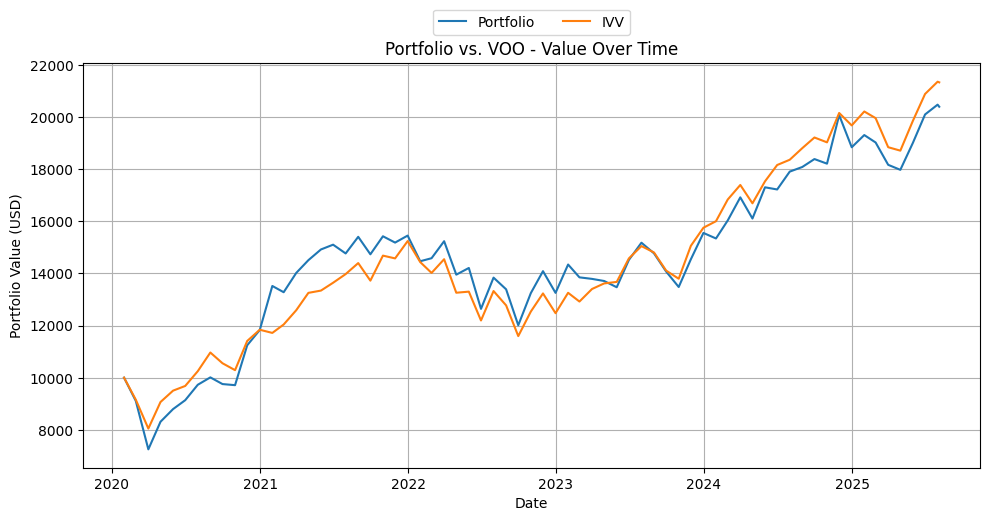

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(portfolio_evolution['date'], portfolio_evolution['position_value'], label='Portfolio')
plt.plot(portfolio_evolution['date'], portfolio_evolution['voo_position_value'], label='IVV')

plt.title('Portfolio vs. VOO - Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)  # Legend above plot
plt.show()


In [40]:
# %pip install plotly

In [41]:
import plotly.graph_objects as go

def plot_each_column_vs_voo(df: pd.DataFrame, columns: list, titles: list = None):
    """
    Plot each specified column from df and VOO columns as separate interactive Plotly charts.
    """
    first_date = df['date'].min() - pd.DateOffset(months=1)
    last_date = df['date'].max() + pd.DateOffset(months=1)
    if titles is None:
        titles = [col.replace('_', ' ').title() for col in columns]
    
    voo_map = {
        'position_value': 'voo_position_value',
        'pct_change_monthly': 'voo_pct_change_monthly',
        'pct_change_since_start': 'voo_pct_change_since_start'
    }
    
    for col, title in zip(columns, titles):
        fig = go.Figure()
        # Portfolio line
        fig.add_trace(go.Scatter(
            x=df['date'],
            y=df[col],
            mode='lines',
            name='Portfolio'
        ))
        # VOO line (if available)
        if col in voo_map:
            fig.add_trace(go.Scatter(
                x=df['date'],
                y=df[voo_map[col]],
                mode='lines',
                name='IVV'
            ))
        fig.update_layout(
            title=title,
            xaxis_title='Date',
            yaxis_title=col.replace('_', ' ').title(),
            hovermode='x unified',
            xaxis=dict(
                range=[first_date, last_date],
                tickformat='%b\n%Y',
                tickangle=0,
                tickmode='auto',
                nticks=12,
                rangeslider=dict(visible=True)
            )
        )
        fig.show()

plot_each_column_vs_voo(
    portfolio_evolution,
    columns=['position_value', 'pct_change_monthly', 'pct_change_since_start'],
    titles=[
        'Portfolio vs. VOO - Value Over Time',
        'Portfolio vs. VOO - Monthly % Change',
        'Portfolio vs. VOO - Cumulative Return Since Start'
    ]
)


##### **7.2 Markowitz (Max Sharpe)**

##### **7.3 Minimum Volatility**

##### **7.4 Momentum**

##### **7.5 Random (baseline)**